In [2]:
%matplotlib inline
import pyfolio as pf

In [4]:
#!/usr/bin/python

import pyfolio as pf
import numpy as np
import pandas as pd
import sys
import subprocess
import logbook
import pytz
import datetime
import matplotlib.pyplot as plt
from adf import test_stocks

zipline_logging= logbook.NestedSetup([logbook.NullHandler(level=logbook.DEBUG),logbook.StreamHandler(sys.stdout,level=logbook.INFO),logbook.StreamHandler(sys.stderr,level=logbook.ERROR),])
zipline_logging.push_application()

from zipline.data.bundles import register,ingest,yahoo_equities
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules, get_environment

beta_hr = test_stocks()

def initialize(context):
    context.long= symbol('MMM')
    context.short= symbol('BA')
    
    context.amlong= False
    context.amshort= False

    schedule_function(place_orders, date_rules.every_day(), time_rules.market_open())
    #schedule_function(stop_loss,date_rules.every_day(), time_rules.market_open())

def before_trading_start(context,data):

    shortclose= data.history(context.short,'close',50,'1d')
    longclose= data.history(context.long,'close',50,'1d')

    res= longclose - beta_hr*shortclose

    context.avg= res.mean()
    context.std= res.std(ddof=0)
'''
def stop_loss(context,data):
    shortc= data.current(context.short,'price')
    longc= data.current(context.long,'price')
    resc= longc- beta_hr*shortc
    if context.amlong== True or context.amshort == True:
        returns= (resc - context.rescur)/context.rescur
        if returns < -0.2:
            order_target_percent(context.long,0)
            order_target_percent(context.short,0)
            context.amlong = False
            context.amshort = False
  '''  
def place_orders(context,data): 
    
    long_percent= (1.0/(1.0+beta_hr))
    short_percent = (1.0- long_percent)

    shortcur= data.current(context.short,'price')
    longcur= data.current(context.long,'price')
    
    rescur= longcur - beta_hr*shortcur
    
    zscore = (rescur-context.avg)/context.std
 
    if context.amlong == True and zscore >= 1.5:
            order_target_percent(context.long, 0)
            order_target_percent(context.short,0)
            context.amlong = False
    elif context.amshort == True and zscore <= -1.5:
            order_target_percent(context.long, 0)
            order_target_percent(context.short,0)
            context.amshort = False
    elif context.amshort == False and zscore >= 2:
        order_target_percent(context.long, -long_percent)
        order_target_percent(context.short, short_percent)
        context.rescur= rescur
        context.amshort= True
    elif context.amlong == False and zscore <= -2:
        order_target_percent(context.long, long_percent)
        order_target_percent(context.short, -short_percent)
        context.rescur= rescur
        context.amlong= True

start= datetime.datetime(1994,9,29,0,0,0,0,pytz.utc)
end = datetime.datetime(2017,4,5,0,0,0,0,pytz.utc)

register('my_bundle',yahoo_equities(('MMM','BA',)))
ingest('my_bundle')

results= run_algorithm(start=start,end=end,initialize=initialize,capital_base=10000,before_trading_start=before_trading_start,data_frequency='daily',bundle='my_bundle')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://statsmodels.sourceforge.net/stable/regression.html


[2017-05-01 00:57:57.344973] WARNING: Loader: Refusing to download new benchmark data because a download succeeded at 2017-04-30 23:59:09.393305+00:00.
[2017-05-01 00:57:57.394506] WARNING: Loader: Refusing to download new treasury data because a download succeeded at 2017-04-30 23:59:11.341305+00:00.
[2017-05-01 00:58:01.228419] INFO: Performance: after split: sid: Equity(1 [BA]), amount: 114.0, cost_basis: 50.88, last_sale_price: 109.875
[2017-05-01 00:58:01.234462] INFO: Performance: returning cash: 0.0
[2017-05-01 00:58:09.419157] INFO: Performance: after split: sid: Equity(0 [MMM]), amount: -216.0, cost_basis: 68.82, last_sale_price: 140.539
[2017-05-01 00:58:09.420940] INFO: Performance: returning cash: 0.0
[2017-05-01 00:58:28.098282] INFO: Performance: Simulated 5670 trading days out of 5670.
[2017-05-01 00:58:28.099380] INFO: Performance: first open: 1994-09-29 13:31:00+00:00
[2017-05-01 00:58:28.100337] INFO: Performance: last close: 2017-04-05 20:00:00+00:00


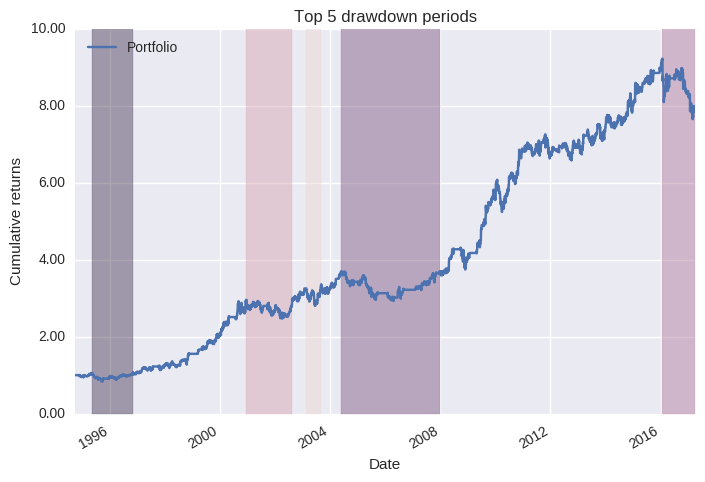

In [5]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')

In [6]:
pf.show_perf_stats(returns=returns, factor_returns= pf.utils.get_symbol_rets('SPY'))

Backtest Months: 270


Performance statistics,Backtest
annual_return,0.10
cum_returns_final,6.90
annual_volatility,0.14
sharpe_ratio,0.74
calmar_ratio,0.44
stability_of_timeseries,0.95
max_drawdown,-0.22
omega_ratio,1.16
sortino_ratio,1.11
skew,0.15


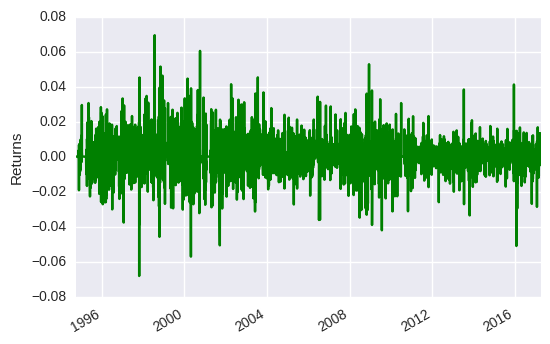

In [11]:
pf.plot_returns(returns =returns)

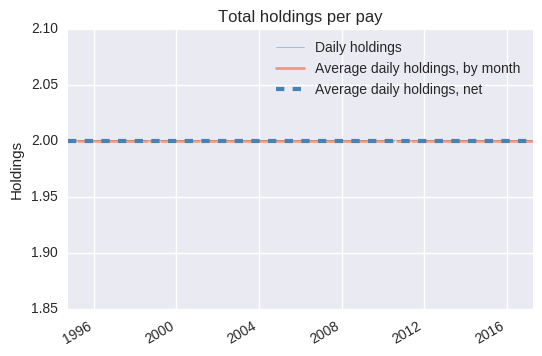

In [12]:
pf.plot_holdings(returns= returns, positions = positions)

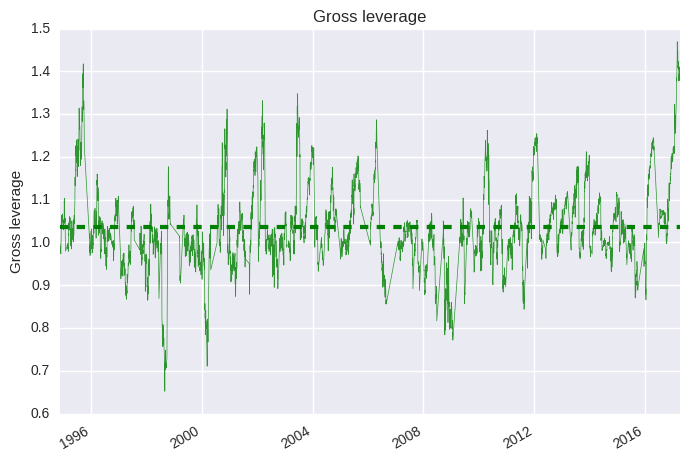

In [7]:
pf. plot_gross_leverage(returns= returns,positions = positions)

In [10]:
print transactions

                           amount commission                        dt  \
1994-09-30 20:00:00+00:00      85       None 1994-09-30 20:00:00+00:00   
1994-09-30 20:00:00+00:00    -121       None 1994-09-30 20:00:00+00:00   
1994-10-06 20:00:00+00:00     -85       None 1994-10-06 20:00:00+00:00   
1994-10-06 20:00:00+00:00     121       None 1994-10-06 20:00:00+00:00   
1994-10-07 20:00:00+00:00      85       None 1994-10-07 20:00:00+00:00   
1994-10-07 20:00:00+00:00    -117       None 1994-10-07 20:00:00+00:00   
1994-11-17 21:00:00+00:00     -85       None 1994-11-17 21:00:00+00:00   
1994-11-17 21:00:00+00:00     117       None 1994-11-17 21:00:00+00:00   
1994-11-18 21:00:00+00:00      84       None 1994-11-18 21:00:00+00:00   
1994-11-18 21:00:00+00:00    -112       None 1994-11-18 21:00:00+00:00   
1994-11-23 21:00:00+00:00     -84       None 1994-11-23 21:00:00+00:00   
1994-11-23 21:00:00+00:00     112       None 1994-11-23 21:00:00+00:00   
1994-11-25 18:00:00+00:00      87     

Entire data start date: 1994-09-29
Entire data end date: 2017-04-05


Out-of-Sample Months: 28
Backtest Months: 241


Performance statistics,All history,Backtest,Out of sample
annual_return,0.08,0.09,-0.02
cum_returns_final,4.68,4.93,-0.04
annual_volatility,0.14,0.15,0.10
sharpe_ratio,0.62,0.68,-0.13
calmar_ratio,0.31,0.35,-0.09
stability_of_timeseries,0.94,0.93,0.09
max_drawdown,-0.26,-0.26,-0.19
omega_ratio,1.13,1.14,0.97
sortino_ratio,0.91,1.01,-0.17
skew,0.11,0.14,-1.21


Worst drawdown periods,net drawdown in %,peak date,valley date,recovery date,duration
0,26.17,2004-05-19,2006-03-21,2007-09-25,875
1,21.96,1995-05-11,1995-09-21,1996-10-25,382
2,19.40,2000-12-12,2002-03-11,2002-10-04,474
3,18.65,2016-01-15,2017-03-01,NaT,NaN
4,18.35,2003-01-31,2003-06-16,2004-03-16,293




[-0.017 -0.036]


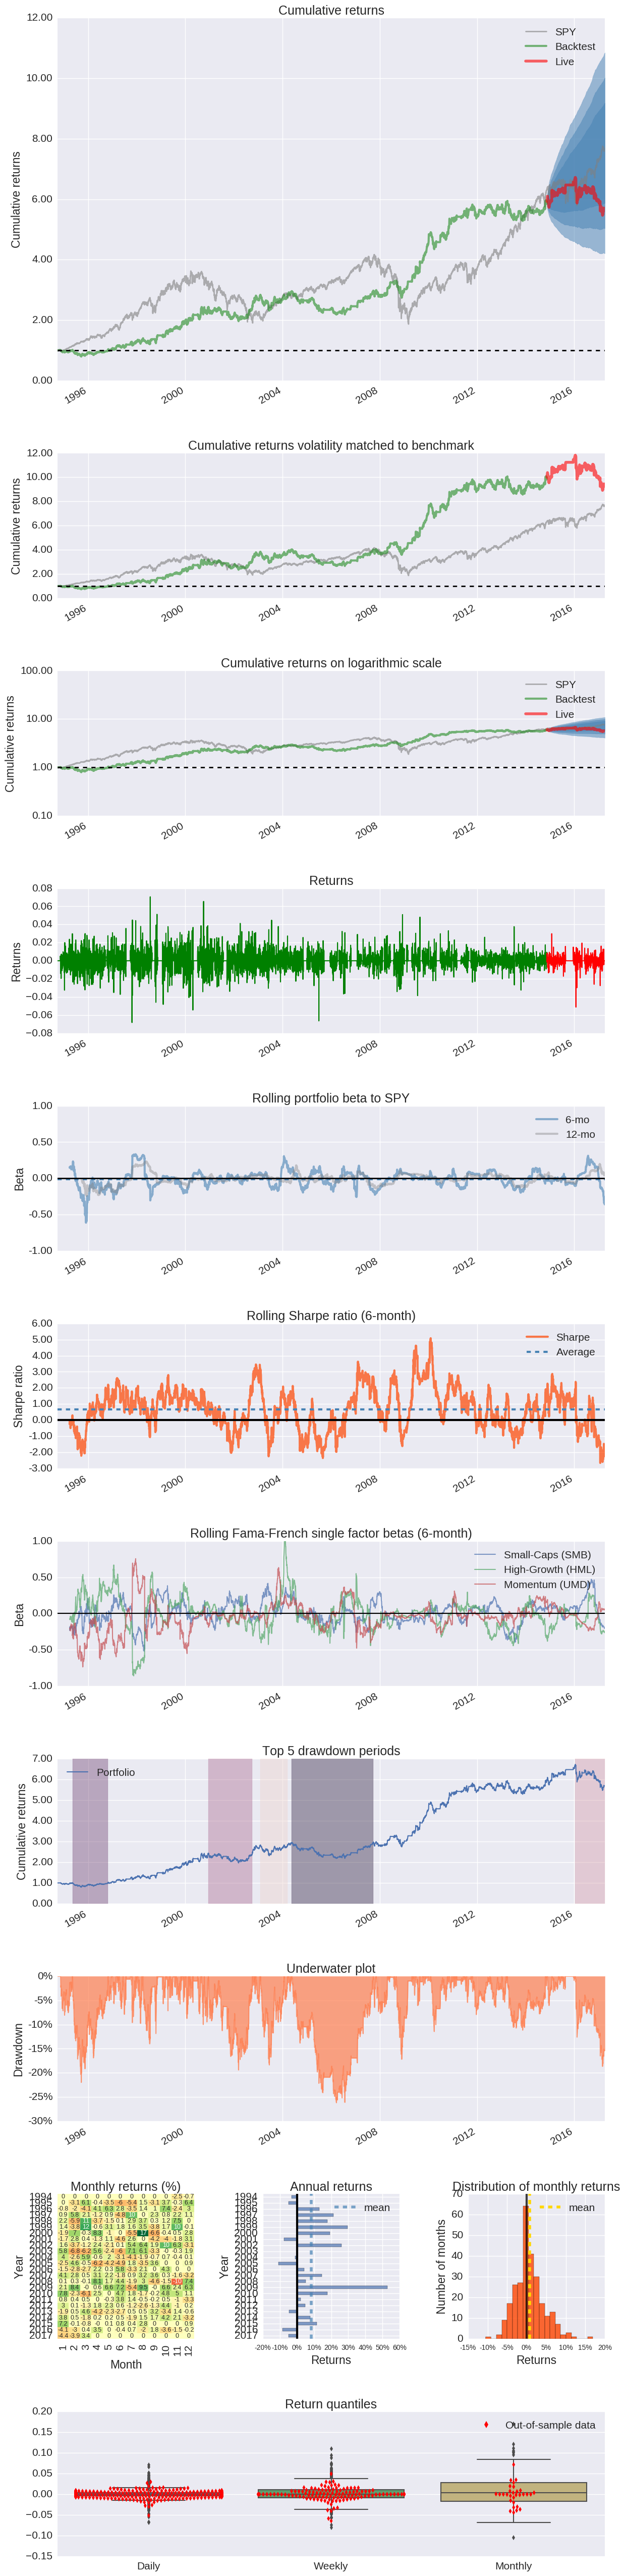

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Stress Events,mean,min,max
Dotcom,0.13%,-5.43%,3.86%
Lehmann,-0.04%,-3.40%,1.82%
9/11,-0.23%,-2.61%,2.18%
US downgrade/European Debt Crisis,0.11%,-1.34%,1.49%
Fukushima,0.00%,0.00%,0.00%
US Housing,0.13%,-1.65%,1.76%
EZB IR Event,-0.10%,-1.32%,0.89%
Aug07,0.14%,-0.69%,1.56%
Mar08,-0.01%,-1.24%,2.42%
Sept08,-0.21%,-3.40%,1.25%


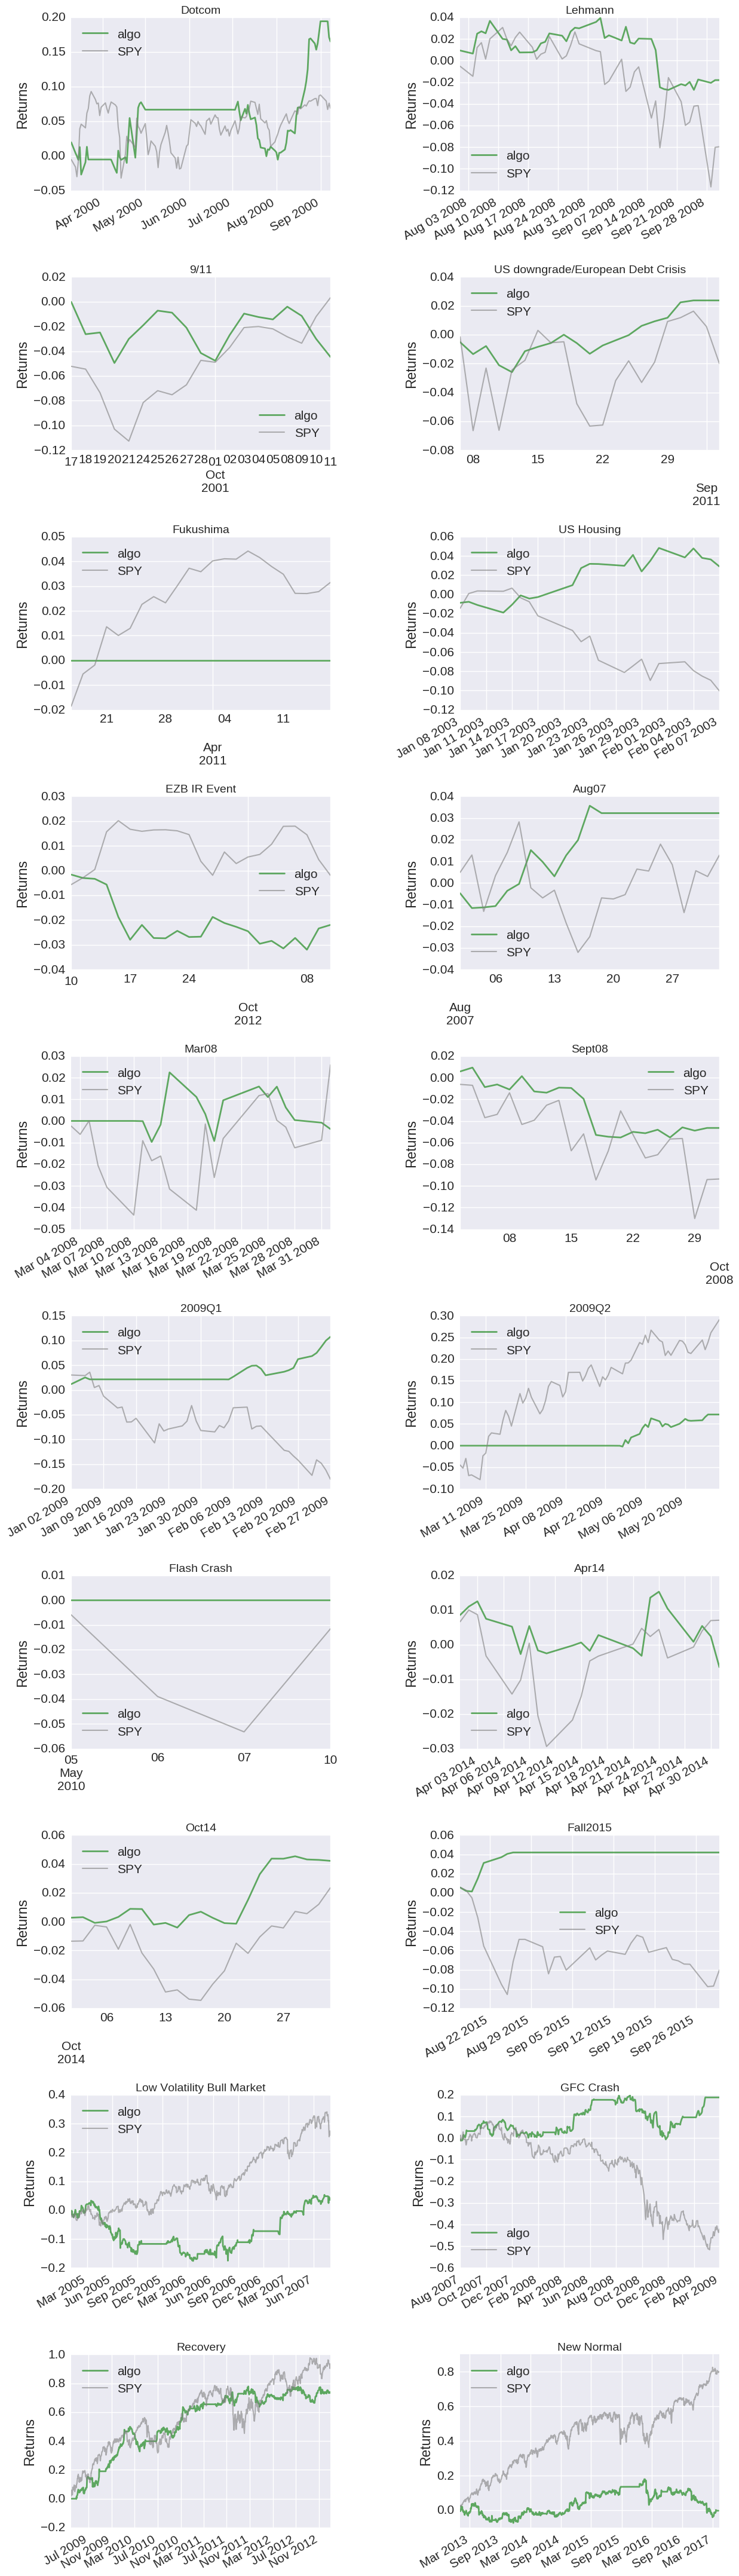

Top 10 long positions of all time,max
BA,66.76%
MMM,63.30%


Top 10 short positions of all time,max
BA,-89.42%
MMM,-63.13%


Top 10 positions of all time,max
BA,89.42%
MMM,63.30%


All positions ever held,max
BA,89.42%
MMM,63.30%


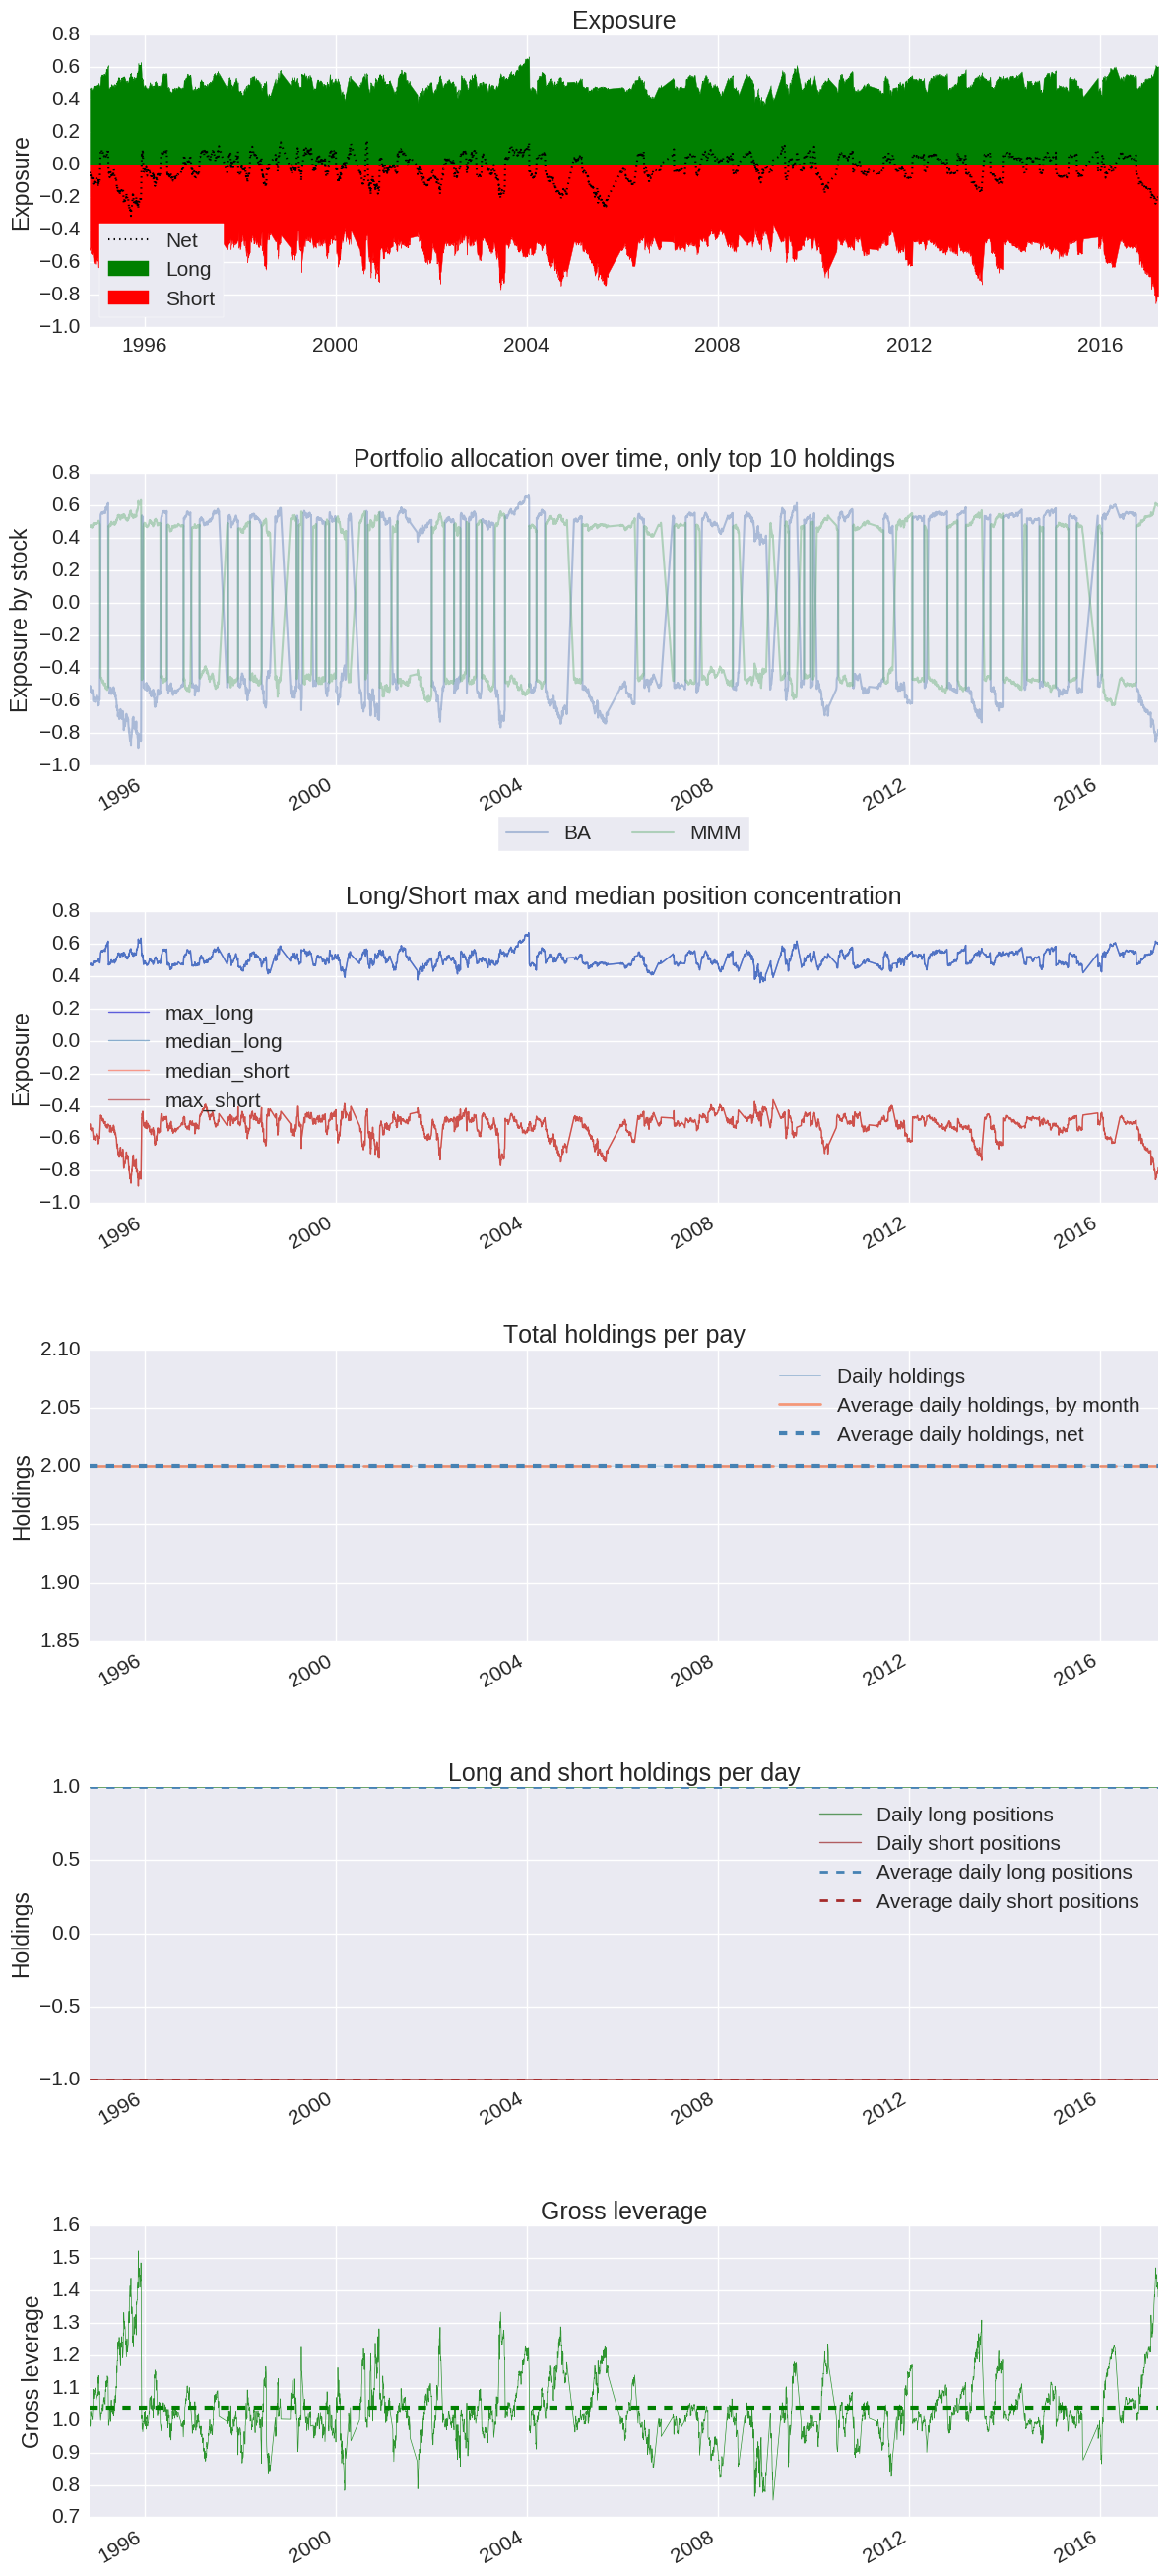

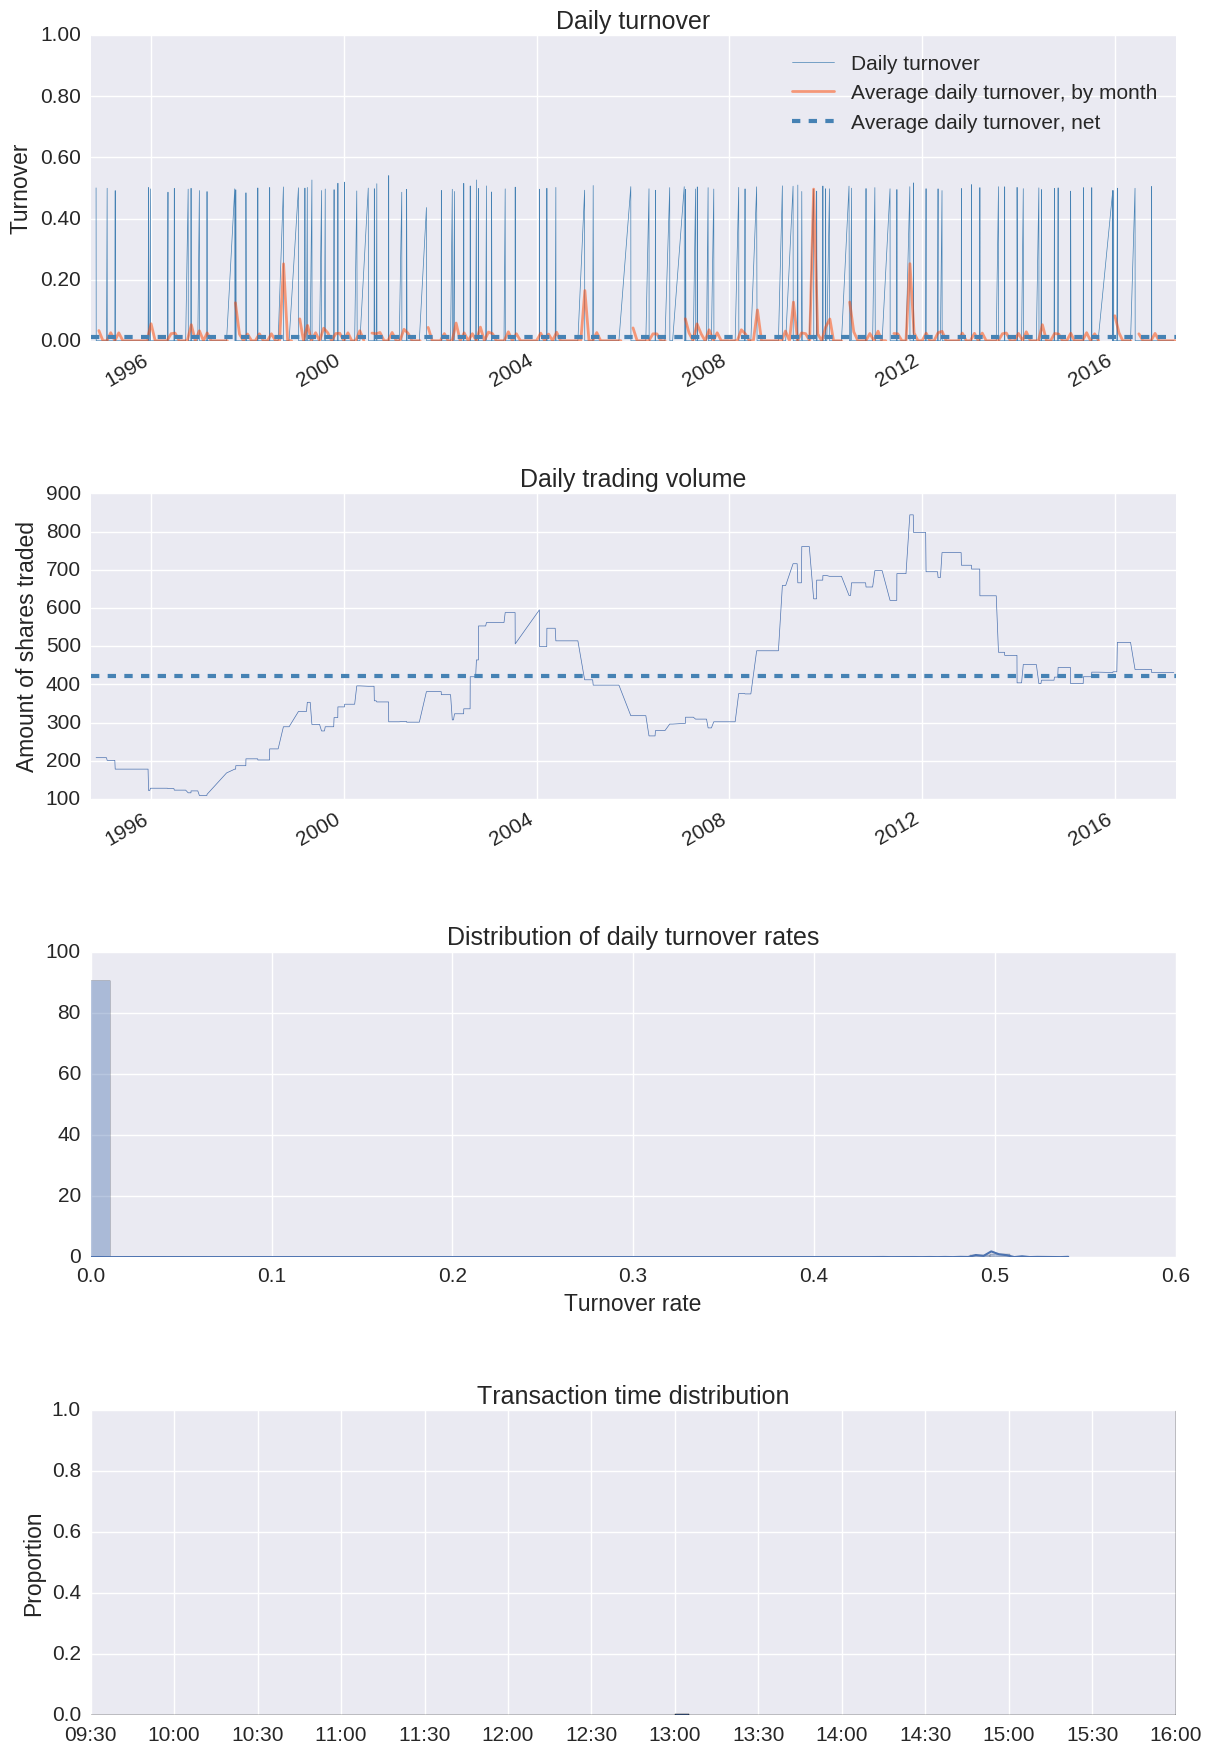

In [35]:
out_of_sample= returns.index[-600]
pf.create_full_tear_sheet(returns=returns, positions=positions, transactions=transactions, live_start_date=out_of_sample)